There have been machine learning projects, such as the [arXiv Classifier](https://github.com/arXiv/arxiv-classifier/), aimed at predicting a preprint's primary arXiv category. Here, based on the text data on math related papers that was gathered and preprocessed in `Scarping and Cleaning the Data.ipynb`, we use Keras to train a convolutional neural network model for this multi-class text classification.   


$\hspace{3cm}$  `cleaned_text`  $\mapsto$ the primary arXiv category (e.g. `math.AG`) $\hspace{1cm}$  (~30 labels).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import pickle as pkl
import gzip

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


import tensorflow as tf
tf.random.set_seed(112024)         #Set the random seed for Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, Dropout, Conv1D,  GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

We first load the data. Among the columns, we only keep `cleaned_text` and `primary_category`.

In [2]:
raw_data=pd.read_csv('./data/data.zip',compression='zip')
data=raw_data[['cleaned_text','primary_category']]
print('Size of the raw data: ',raw_data.shape[0])
data.head()

Size of the raw data:  164230


,cleaned_text,primary_category
0,massiv parallel eulerian lagrangian method adv...,cs.CE
1,algebra irreduc modul varieti iii birkhoff var...,math.RT
2,exist smooth orbit varieti simpl lie algebra o...,math.RT
3,polyhedr realize crystal base convex geometr d...,math.AG
4,high curv orbit space infimum section curvatur...,math.DG


Starting data visualization: which arXiv categories have been the most prevalent as the primary? 

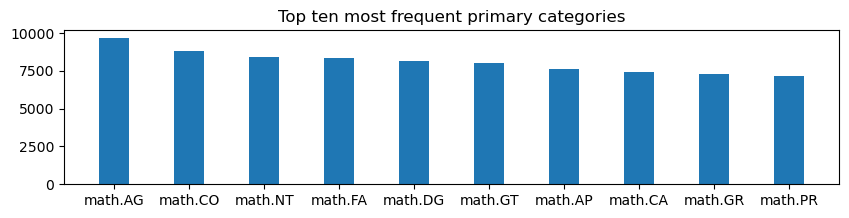

In [3]:
fig=plt.figure(figsize=(10,2))
ax=fig.add_subplot(1,1,1)

#Top 10 most frequent primary categories (bar chart)
ax.bar(x=raw_data['primary_category'].value_counts().head(10).index, 
        height=raw_data['primary_category'].value_counts().head(10),width=0.4)
ax.set_title('Top ten most frequent primary categories')

plt.show()

There are labels with very low frequency. 

In [4]:
data['primary_category'].value_counts().head(40)

primary_category
math.AG     9694
math.CO     8838
math.NT     8380
math.FA     8377
math.DG     8126
math.GT     7992
math.AP     7621
math.CA     7430
math.GR     7303
math.PR     7157
math.RA     6231
math.DS     6150
math.RT     6097
math.CV     5931
math.NA     5570
math.AC     4989
math.AT     4665
math.OA     4312
math.LO     4295
math.QA     3652
math.ST     3546
math.MG     3379
math-ph     3343
math.OC     3197
math.SG     2437
math.SP     2347
math.CT     2009
math.GN     1995
math.GM     1699
math.HO     1250
math.KT     1163
cs.IT        694
stat.ME      371
quant-ph     322
cs.LG        264
nlin.SI      243
q-bio.PE     205
stat.ML      183
gr-qc        179
hep-th       177
Name: count, dtype: int64

Observe that labels which are not from math archive appear scarcely. We drop those labels, and one-hot encode the remaining labels. 

In [5]:
data=data[data['primary_category'].apply(lambda x:x.startswith('math'))][['cleaned_text','primary_category']]
data.reset_index(inplace=True)
MathCat_list=list(data['primary_category'].unique())
lb=LabelBinarizer()
lb.fit(MathCat_list)      #Caution: The order of labels stored in lb is not necessarily the same as MathCat_list; lb.classes_ should be used instead.
data=pd.concat((data['cleaned_text'],pd.DataFrame(lb.transform(data['primary_category']),columns=lb.classes_,dtype=int))
               ,axis=1)

#Saving the encoded data in a compressed form.     
data.to_csv('./data/data_encoded_CatPred.zip',compression='zip',index=False)

We next split the data into train and test sets in a way that labels are distributed evenly. We save the corresponding row indices for future use.

In [6]:
#https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn
X_train,X_test,y_train,y_test=train_test_split(data['cleaned_text'],data.iloc[:,1:],test_size=0.25,random_state=1,
                                             stratify=data.iloc[:,1:])
train_index=np.asarray(X_train.index).tolist()
print(f'The number of training instances: {len(train_index)}')
with open('./data/train_index_CatPred.json','w') as file:
    json.dump(train_index,file)
    
test_index=np.asarray(X_test.index).tolist()
print(f'The number of test instances: {len(test_index)}')
with open('./data/test_index_CatPred.json','w') as file:
    json.dump(test_index,file)

The number of training instances: 119381
The number of test instances: 39794


Making sure no label is all zero in either the training or the test set. 

In [7]:
print(f'The number of all-zero columns in y_train is {np.sum((np.sum(y_train,axis=0)==0).astype(int))}.\n')

print(f'The number of all-zero columns in y_test is {np.sum((np.sum(y_test,axis=0)==0).astype(int))}.')

The number of all-zero columns in y_train is 0.

The number of all-zero columns in y_test is 0.


The next setp is to [tokenize](https://neptune.ai/blog/tokenization-in-nlp) the text. How many words appear in the text data overall or on average? 

In [8]:
vocabulary = set()
X_train.str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(f'Vocabulary size: {vocabulary_size}')

X_train.apply(lambda x: len(x.split(" "))).describe()

Vocabulary size: 71614


count    119381.000000
mean         56.342718
std          28.880416
min           2.000000
25%          35.000000
50%          51.000000
75%          71.000000
max         219.000000
Name: cleaned_text, dtype: float64

The text is already cleaned, everything lower-case and no stop word, punctuation or special character. Thus there is no need to pass `filter` to `Tokenizer`.

In [9]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

We apply padding to turn all sequences into the same length. As observed above, most inputs have less than 100 words. Hence we set `maxlen=100` in Keras' `pad_sequences`. 

In [10]:
X_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(X_train, maxlen=100, padding='post')
print(X_train)

X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test, maxlen=100, padding='post')
print(X_test)

[[1740  510  204 ...    0    0    0]
 [ 528   68 1161 ...    0    0    0]
 [ 747  478   92 ...  336 1257  116]
 ...
 [  25  324    3 ...    0    0    0]
 [2538 2437  845 ...    0    0    0]
 [ 291 3340  323 ...    0    0    0]]
[[  37   97   21 ...    0    0    0]
 [  43  244 1092 ...    0    0    0]
 [ 170 1468  283 ...    0    0    0]
 ...
 [1780   12  159 ...    0    0    0]
 [  34   45 1716 ...    0    0    0]
 [1296 3335  247 ...    0    0    0]]


Now we create a convolutional neural network model for our text classification problem. 

In [11]:
clf_nn=Sequential()

#The embedding layer
#We add 1 because the embedding layer is zero-based 
#https://stackoverflow.com/questions/72263400/why-in-keras-embedding-layers-matrix-is-a-size-of-vocab-size-1
clf_nn.add(Embedding(input_dim=vocabulary_size+1, output_dim=50, input_length=100))

#Adding a dropout layer
clf_nn.add(Dropout(0.3))

#Adding a convolutional layer
clf_nn.add(Conv1D(200,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1))

#We use max pooling:
clf_nn.add(GlobalMaxPooling1D()) 

#We add a vanilla hidden layer:
clf_nn.add(Dense(200))

#Adding another dropout layer
clf_nn.add(Dropout(0.3))
clf_nn.add(Activation('relu'))

# Adding a dense output layer with softmax activation
clf_nn.add(Dense(31, activation='softmax'))
clf_nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           3580750   
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 conv1d (Conv1D)             (None, 98, 200)           30200     
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                       

The cells below train the model and plot the loss and accuracy over training and validation sets versus epochs. The task is multi-class classification, so  the last layer of the network above had `softmax` activation, and we should use `loss='categorical_crossentropy'` in training (see [here](https://stackoverflow.com/a/59433454/13036105) for more details). 

In [12]:
#Forming a dictionary for class weights: each class index will be associated with a number inversely proportional with its frequency.
#(All weights would be 1 if classes are completely balanced.)
#This causes the model to pay more attention to underrepresented labels.  
temp=y_train.sum()
class_weight={}
for i in range(temp.shape[0]):
    class_weight[i]=y_train.shape[0]/(temp[i]*y_train.shape[1])


#Early stopping, the training stops if validation loss does not decrease for five epochs. 
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

opt=Adam(learning_rate=0.00008)
clf_nn.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = clf_nn.fit(X_train, (y_train),
                    epochs=100,
                    batch_size=32,
                    validation_split=0.3,class_weight=class_weight,
                    callbacks=[es])

Epoch 1/100


2612/2612 [==============================] - 90s 34ms/step - loss: 3.2814 - accuracy: 0.0914 - val_loss: 2.8719 - val_accuracy: 0.2344
Epoch 2/100
2612/2612 [==============================] - 90s 34ms/step - loss: 2.5614 - accuracy: 0.2638 - val_loss: 2.2995 - val_accuracy: 0.3700
Epoch 3/100
2612/2612 [==============================] - 76s 29ms/step - loss: 2.1567 - accuracy: 0.3712 - val_loss: 1.9820 - val_accuracy: 0.4446
Epoch 4/100
2612/2612 [==============================] - 75s 29ms/step - loss: 1.8969 - accuracy: 0.4402 - val_loss: 1.7831 - val_accuracy: 0.4949
Epoch 5/100
2612/2612 [==============================] - 73s 28ms/step - loss: 1.7160 - accuracy: 0.4903 - val_loss: 1.6359 - val_accuracy: 0.5343
Epoch 6/100
2612/2612 [==============================] - 73s 28ms/step - loss: 1.5809 - accuracy: 0.5294 - val_loss: 1.5282 - val_accuracy: 0.5609
Epoch 7/100
2612/2612 [==============================] - 73s 28ms/step - loss: 1.4751 - accuracy: 0.5582 - val_loss:

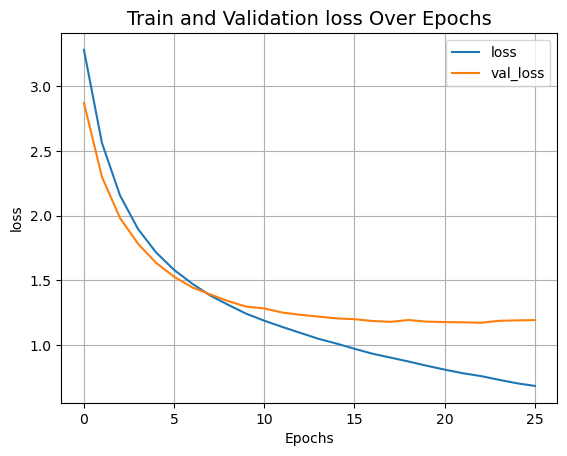

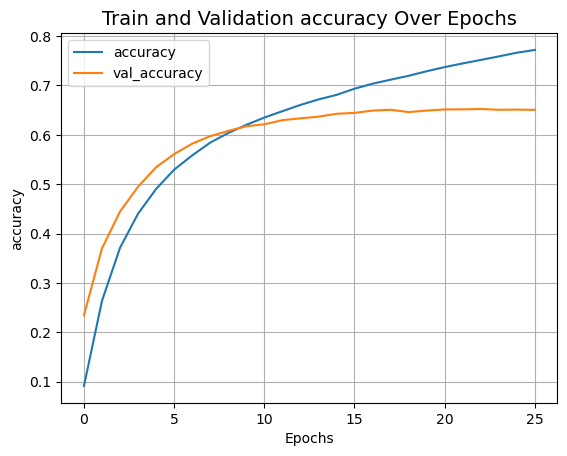

In [13]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.locator_params(axis='x', integer=True)
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

Loss and accuracy over the test set:

In [14]:
[test_loss,test_accuracy]=clf_nn.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {round(100*test_accuracy,2)}%')

1244/1244 [==============================] - 5s 4ms/step - loss: 1.1777 - accuracy: 0.6552
Test loss: 1.1777474880218506
Test accuracy: 65.52%


Indeed, we can compute other metrics over the test set as well.

In [15]:
#Consists of probabilities
y_pred_train_proba=clf_nn.predict(X_train)
y_pred_proba=clf_nn.predict(X_test) 


#Predicted labels based on predicted probabilities.
#https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0?rq=3
y_pred_train=(y_pred_train_proba==y_pred_train_proba.max(axis=1)[:,None]).astype(int)
y_pred=(y_pred_proba==y_pred_proba.max(axis=1)[:,None]).astype(int)


print('\nMetrics for predicting the primary arXiv category based on the cleaned text:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score micro: {round(100*f1_score(y_train, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score macro: {round(100*f1_score(y_train, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train, y_pred_train, average='weighted'),2)}%")



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%")  

1244/1244 [==============================] - 5s 4ms/step

Metrics for predicting the primary arXiv category based on the cleaned text:

 Train Accuracy: 77.33%
 Train F1-score micro: 77.33%
 Train F1-score macro: 76.19%
 Train F1-score weighted: 77.48%
 
 Test Accuracy:  65.52%
 Test F1-score micro: 65.52%
 Test F1-score macro: 63.01%
 Test F1-score weighted: 65.8%


Visualizing the model's ability to distinguish the more common labels on the test set:

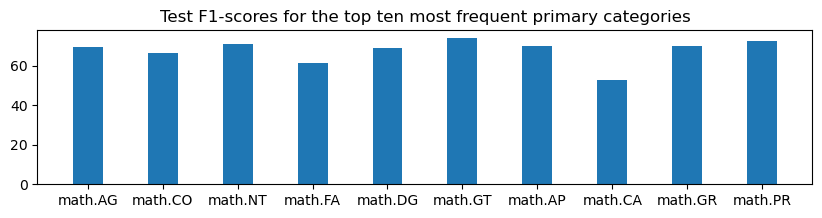

In [16]:
fig=plt.figure(figsize=(10,2))
ax=fig.add_subplot(1,1,1)

f1_percentages=100*f1_score(y_test, y_pred, average=None)

top_index=np.argsort(np.asarray((-data.iloc[:,1:]).sum()))[:10]
top_categories=(-data.iloc[:,1:]).sum().index[top_index]

#Top 10 most frequent primary categories (bar chart)
ax.bar(x=top_categories, 
        height=f1_percentages[top_index],width=0.4)
ax.set_title('Test F1-scores for the top ten most frequent primary categories')

plt.show()

Saving the trained models along with the names of their variables:

In [17]:
#We first pickle the trained models and then zip them. 
#https://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pkl.dump(obj, f, protocol)

save_zipped_pickle(tokenizer,'./models/tokenizer.gz')
save_zipped_pickle(clf_nn,'./models/clf_nn.gz')

with open('./models/Cat_list.json','w') as file:
    json.dump(list(data.columns[1:]),file)

Some useful links
*******************************************************************
CNN for text classification)  
https://www.davidsbatista.net/blog/2018/03/31/SentenceClassificationConvNets/


Introduction to Keras)  
https://blog.paperspace.com/the-absolute-guide-to-keras/


Some interesting multi-class text classification projects with neural networks)  
https://www.kaggle.com/code/kadhambari/multi-class-text-classification  
https://medium.com/analytics-vidhya/multiclass-text-classification-using-deep-learning-f25b4b1010e5


Keras for multi-label text classification)  
https://keras.io/examples/nlp/multi_label_classification/